In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
rcParams['figure.figsize'] = 16,4

In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [59]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [60]:
weekofsun = pd.date_range('2017-12-01', periods = round(len(tmp['order_date'].unique())/7), freq = 'W-SUN')
weekofsun

DatetimeIndex(['2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24',
               '2017-12-31', '2018-01-07', '2018-01-14', '2018-01-21',
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15',
               '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
               '2018-06-17', '2018-06-24', '2018-07-01', '2018-07-08',
               '2018-07-15', '2018-07-22', '2018-07-29', '2018-08-05',
               '2018-08-12', '2018-08-19', '2018-08-26', '2018-09-02',
               '2018-09-09', '2018-09-16', '2018-09-23', '2018-09-30',
               '2018-10-07', '2018-10-14', '2018-10-21', '2018-10-28',
               '2018-11-04', '2018-11-11', '2018-11-18', '2018-11-25',
               '2018-12-02', '2018-12-09', '2018-12-16', '2018-12-23',
      

In [61]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
useful_dot_name.head()

,dot
65,东丽机场点部
85,东升三角点部
91,东升宝丰点部
146,中山沙溪点部
148,中山港义点部


In [62]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,常熟董浜点部,2017-12-01,29
2017-12-01,江宁保税区点部,2017-12-01,70
2017-12-01,厦门前埔点部,2017-12-01,39
2017-12-01,滨海沙城点部,2017-12-01,24


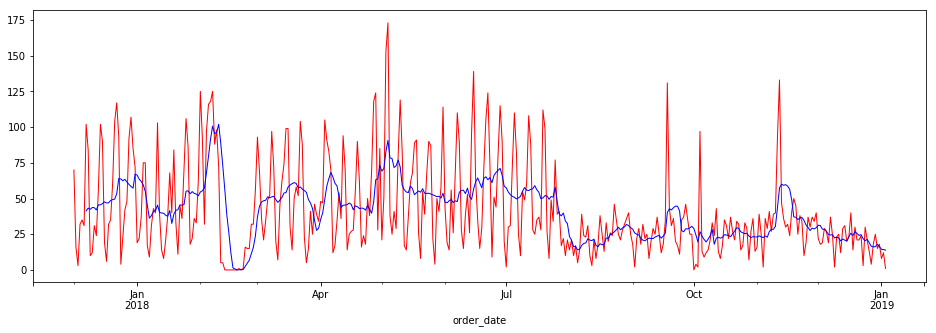

In [76]:
result_ts = result_data.loc[result_data['dot'] == '江宁保税区点部', ['order_num']]  
# result_ts = np.log1p(result_ts)
result_ts = result_ts['order_num'].resample('D').sum()
# result_ts = result_ts.loc[~result_ts.index.isin(weekofsun)]
result_ts.plot(figsize = (16,5), color = 'r', linewidth=1)
result_ts.rolling(window = 7).mean().dropna().plot(figsize = (16,5), color = 'b', linewidth=1)

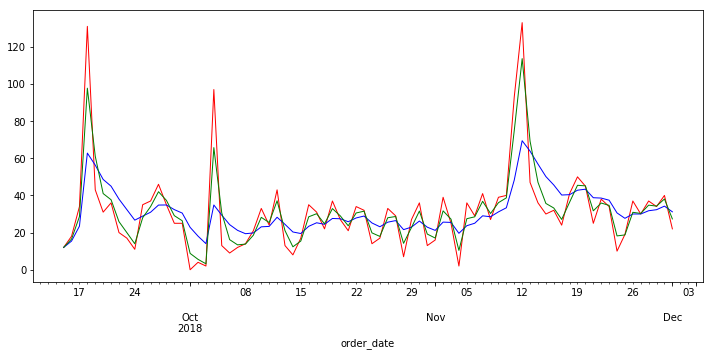

In [78]:
result_ts['2018-09-15':'2018-12-01'].plot(figsize = (12,5), color = 'r', linewidth=1)
result_ts['2018-09-15':'2018-12-01'].ewm(span = 7).mean().plot(figsize = (12,5), color = 'b', linewidth=1)
result_ts['2018-09-15':'2018-12-01'].ewm(span = 2).mean().plot(figsize = (12,5), color = 'g', linewidth=1)

In [51]:
np.random.randint( low=1,high = 1115, size = 3 )

array([ 45, 456, 206])

In [49]:
result_ts_train = result_ts[ : -10]
result_ts_test = result_ts[-10 : ]

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts, lags=lag) #lags可自定义
    return p_value
test_stochastic(result_ts_train,1)[1][0]

2.6820955063057012e-20

In [65]:
dftest = adfuller(result_ts_train)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                  -4.469328
p-value                          0.000223
#Lags Used                      14.000000
Number of Observations Used    374.000000
Critical Value (1%)             -3.447956
Critical Value (5%)             -2.869299
Critical Value (10%)            -2.570903
dtype: float64

In [63]:
import warnings
warnings.filterwarnings("ignore")
temp = {}
for p in range(0,6):
    for q in range(0,6):
        try:
            temp[str(p) + '_' + str(q)] = (ARMA(result_ts_train, order=(p, q)).fit().aic)
        except:
            continue
tmp = sorted(temp.items(), key = lambda x : x[1], reverse = False)
p, q = tmp[0][0].split('_')
print(p, q)

5 5


In [66]:
arma_model = ARMA(result_ts_train, order = (int(p), int(q))).fit()

In [67]:
arma_result = arma_model.predict()

Text(0.5,1,'TRAIN_RSME : 0.7754')

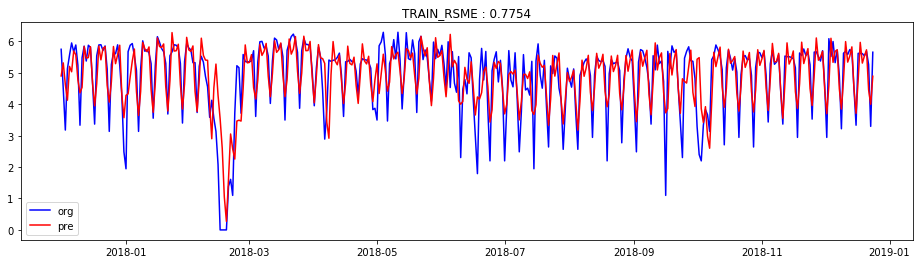

In [68]:
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(arma_result, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((arma_result - result_ts_train) ** 2)/len(result_ts_train)))

In [69]:
test_result = arma_model.predict(result_ts_test.index[0].strftime('%Y-%m-%d'), result_ts_test.index[-1].strftime('%Y-%m-%d'), dynamic = True)

Text(0.5,1,'TEST_RSME : 1.3961')

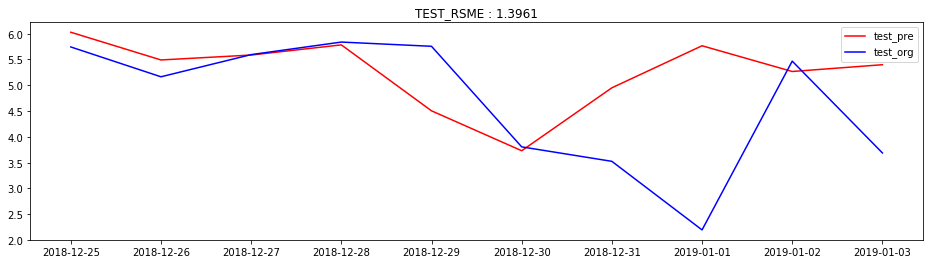

In [72]:
plt.plot(test_result, label = 'test_pre', color = 'r')
plt.plot(result_ts_test, label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("TEST_RSME : %.4f" % np.sqrt(np.sum((result_ts_test - test_result) ** 2)/len(test_result)))

Text(0.5,1,'TEST_RSME : 144.4982')

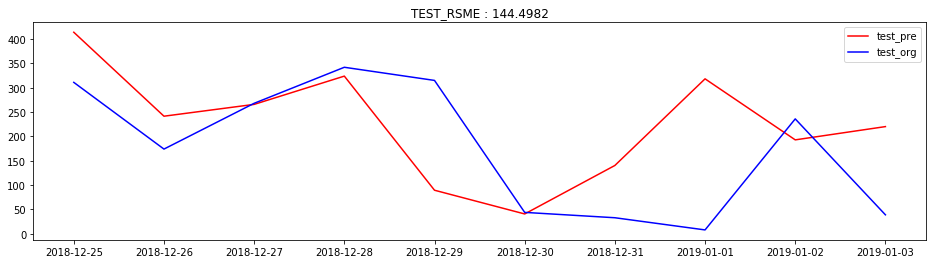

In [80]:
plt.plot(np.expm1(test_result), label = 'test_pre', color = 'r')
plt.plot(np.expm1(result_ts_test), label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("TEST_RSME : %.4f" % np.sqrt(np.sum((np.expm1(result_ts_test) - np.expm1(test_result)) ** 2)/len(np.expm1(test_result))))

In [82]:
accurate=[]
for i in range(len(test_result)):
     accurate.append(min(np.expm1(test_result)[i], np.expm1(result_ts_test)[i])/max(np.expm1(test_result)[i], np.expm1(result_ts_test)[i]))
accurate = pd.DataFrame(accurate, index = result_ts_test.index, columns = ['acc_rate'])
print("Mean acc_rate : %.4f" % accurate.acc_rate.mean())
for i, j in zip(np.expm1(result_ts_test), np.expm1(test_result)):
    print(int(i),int(j))

Mean acc_rate : 0.5876
311 413
174 241
268 265
341 323
315 89
43 40
33 140
8 318
236 192
39 220
